In [1]:
using Distributions, LinearAlgebra, Plots, Plots.PlotMeasures, Random, LargeMessageCollider
Random.seed!(1234);

In [2]:
# Generate a synthetic data
A = [1 0.1; 0 1]
B = [1 0]
Q = [0.1^3/3 0.1^2/2; 0.1^2/2 0.1]
R = [1.,2.]

C = [0.9 0.15; 0.1 0.85]

T = 100

z_real = []
x_real = zeros(2,T)
y_real = zeros(T)

push!(z_real, rand(Categorical(ones(2)./2)))
x_real[:,1] = rand(MvNormal(zeros(2),diagm(0=>ones(2))))
y_real[1] = rand(Normal((B*x_real[:,1])[1],R[z_real[1]]))
for t=2:T
    push!(z_real, rand(Categorical(C[:,z_real[t-1]])))
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[t] = rand(Normal((B*x_real[:,t])[1],R[z_real[t]]))
end

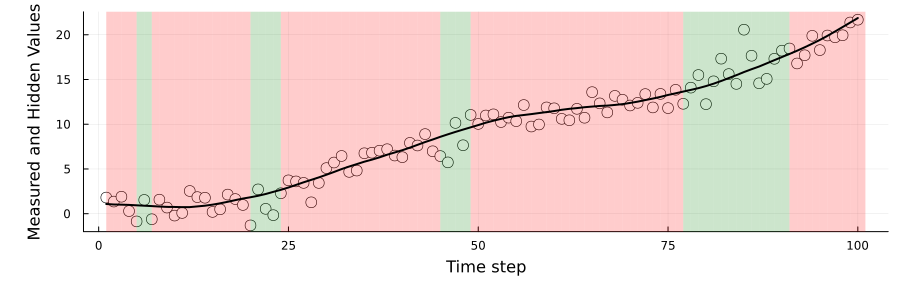

In [3]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false)
colors_list = [:red, :green]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Measured and Hidden Values")

plot!(x_real[1,:], color=:black, lw=2)
plot(s1, size=(900,300), bottom_margin = 10mm, left_margin=10mm)

$$
p(z_1) p(x_1) p(y_1|x_1, z_1) \prod\limits_{t=2}^{T} p(z_t|z_{t-1}) p(x_t|x_{t-1}) p(y_t|x_t, z_t)
$$

In [4]:
# Priors
px1 = MvNormal(zeros(2),diagm(0=>ones(2)))
pz1 = Categorical(ones(2)./2)
;

In [5]:
vmp = VMP() # a VMP instance to enable VMP message passing
# Filtering method for continuous states
function filter(qz, T)
    forward_estimates = Array{MvNormal}(undef, T)
    scale = sqrt.(qz[1].p' * R.^2) 
    measure = B\Normal(y_real[1],scale) # VMP message
    forward_estimates[1] = px1 * measure # Update
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Q) # prediction belief
        scale = sqrt.(qz[t].p' * R.^2)
        measure = B\Normal(y_real[t],scale) # VMP message
        forward_estimates[t] = predict * measure
    end
    return forward_estimates
end

# Smoothing method for continuous states
function smooth(forward_estimates, T)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,inv(Q))
    end
    return smooth_estimates, joint_dists
end

function update_qx(qz, T)
    forward_estimates = filter(qz, T)
    smooth_estimates, joint_dists = smooth(forward_estimates, T)
    return smooth_estimates, joint_dists
end
;

In [6]:
function update_qz(qx, T)
    # Utility function sending message upward as categorical dist
    function message_up(y,t)
        #emission = [Normal(mean(B*qx[t]), R[1]), Normal(mean(B*qx[t]), R[2])]
        emission = [B*qx[t] + Normal(0,R[1]), B*qx[t] + Normal(0,R[2])]
        logp = logpdf.(emission, y) # calculate logpdfs
        p = normalize_logprob_array(logp) # probability of categories. log-sum-exp followed by normalization
        Categorical(p) # Categorical message
    end
    
    # Forward Pass
    forward_estimates = Array{Categorical}(undef, T)
    measure = message_up(y_real[1],1) # measurement belief 
    forward_estimates[1] = pz1 * measure # update step

    for t=2:T
        predict = C*forward_estimates[t-1] # prediction belief
        measure = message_up(y_real[t],t) # measurement belief
        forward_estimates[t] = predict * measure # update step
    end
    
    # Correction Smoothing
    smooth_estimates = Array{Categorical}(undef, T)
    smooth_estimates[T] = forward_estimates[T]

    joint_dists = Array{Matrix}(undef, T-1)

    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],C)
    end
    return smooth_estimates, joint_dists
end
;

In [7]:
# Initialize variational distributions qz
qz = Array{Categorical}(undef, T)
qx = Array{MvNormal}(undef, T)
for t=1:T qz[t] = Categorical([0.5, 0.5]) end

n_its = 10 # number of iterations
FE = zeros(n_its) # store Free energy

# Variational updates
for i=1:n_its
    qx, qx_joints = update_qx(qz,T)
    qz, qz_joints = update_qz(qx, T)
    
    # Calculate Free Energy
    F = - entropy(qx[1]) - entropy(qz[1])
    F += cross_entropy(qx[1], px1) + cross_entropy(qz[1], pz1)
    for t=1:T-1
        F -= normal_conditional_entropy(qx[t], qx[t+1], qx_joints[t])
        F -= categorical_conditional_entropy(qz_joints[t])
        # -∑_{z[t]}∑_{z[t-1]}q(z_{t},z_{t-1})*logp(z_{t}|z_{t-1})
        transit_z = -sum(qz_joints[t] .* log.(C))
        F += transit_z
        # -∫q(x_{t},x_{t-1})*logp(x_{t}|x_{t-1}) dx_{t} dx_{t-1}
        k = 2
        q1, q2, q21 = qx[t], qx[t+1], qx_joints[t]
        V_inv = squaremean(q2) - (squaremean(q21)[1:k,k+1:2*k])*A' - A*(squaremean(q21)[k+1:2*k,1:k]) + A*squaremean(q1)*A'
        transit_x = k/2*log(2*pi) + log(det(Q))/2 + tr(V_inv*inv(Q))/2
        F += transit_x
        # Energy term
        energy = qz[t].p[1]/2 * (log(2*pi) + 2*log(R[1]) + (y_real[t]^2 - 2*y_real[t]*mean(B*qx[t]) + squaremean(B*qx[t]))/R[1]^2)
        energy += qz[t].p[2]/2 * (log(2*pi) + 2*log(R[2]) + (y_real[t]^2 - 2*y_real[t]*mean(B*qx[t]) + squaremean(B*qx[t]))/R[2]^2)
        F += energy
    end
    # Final Energy term
    energy = qz[T].p[1]/2 * (log(2*pi) + 2*log(R[1]) + (y_real[T]^2 - 2*y_real[T]*mean(B*qx[T]) + squaremean(B*qx[T]))/R[1]^2)
    energy += qz[T].p[2]/2 * (log(2*pi) + 2*log(R[2]) + (y_real[T]^2 - 2*y_real[T]*mean(B*qx[T]) + squaremean(B*qx[T]))/R[2]^2)
    F += energy
    FE[i] = F
end

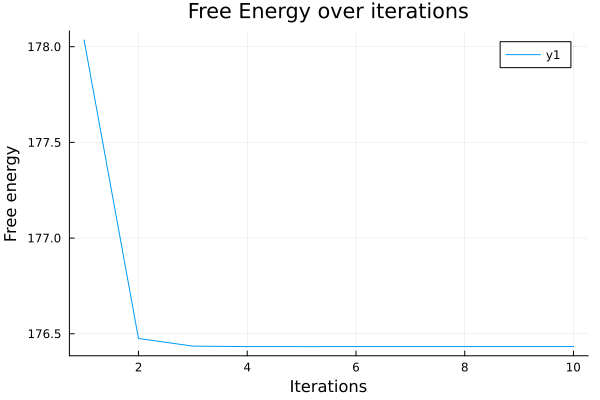

In [8]:
plot(FE, title="Free Energy over iterations", xlabel="Iterations", ylabel="Free energy")

In [9]:
FE

10-element Vector{Float64}:
 178.03483033877924
 176.4751869518837
 176.43517572822148
 176.43291254027278
 176.4328157726274
 176.4328288129071
 176.43283495182484
 176.43283657551953
 176.4328369333828
 176.4328370098151

Free Energy does not decrease steadily over iterations. This could be due to rounding errors or even numerical corrections to preserve positive definiteness. Requires further investigation.

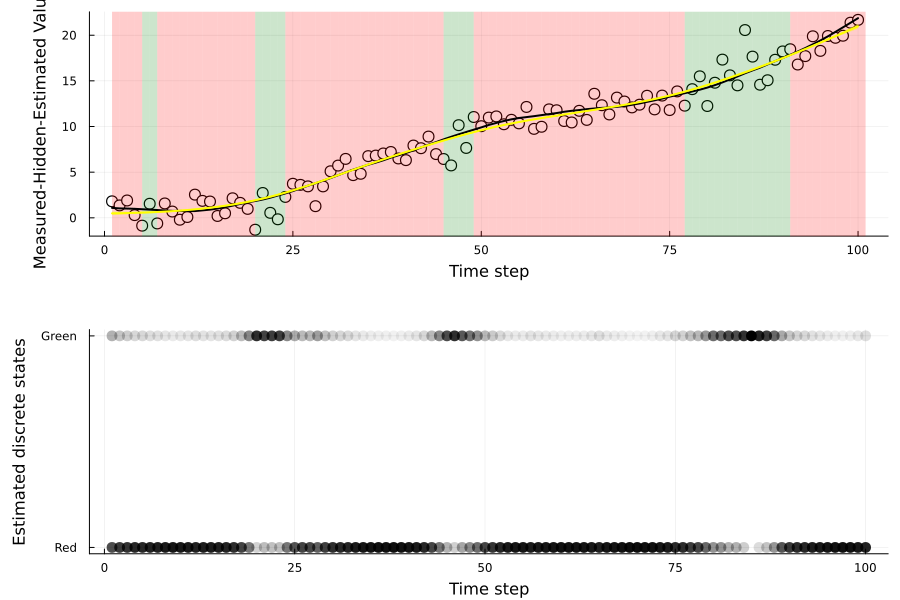

In [10]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false, bottom_margin = 10mm, left_margin=10mm)
colors_list = [:red, :green]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Measured-Hidden-Estimated Values")

plot!(x_real[1,:], color=:black, lw=2)

smooth_m, smooth_v = zeros(T), zeros(T)
for t=1:T
    smooth_m[t] = mean(qx[t])[1]
    smooth_v[t] = cov(qx[t])[1,1]
end
plot!(smooth_m, lw=2, color=:yellow, ribbon=smooth_v, fillalpha=0.4)

s2 = scatter((1,1),markeralpha=qz[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=qz[1].p[2], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=qz[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=qz[t].p[2], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=qz[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=qz[T].p[2], color=:black, markersize=6)

xaxis!("Time step")
yaxis!("Estimated discrete states")
yticks!([1,2],["Red", "Green"])

plot(s1, s2, layout = (2, 1), size=(900,600))